In [10]:
from astropy.io import fits
import astropy
import glob,os
from matplotlib import pyplot as plt
import numpy as np
import warnings
%matplotlib inline

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
import datetime
from PIL import Image
import subprocess

from PIL import Image, ImageDraw, ImageFont

from astropy.table import Table

### From Mike's code: https://github.com/zooniverse/decals/tree/master/decals

In [44]:
# Download fits images from DeCALS and produce colour images


def download_images(galaxy, radius,
                    data_release,
                    overwrite_fits=False,
                    overwrite_png=False,
                    max_attempts=5,
                    min_pixelscale=0.1,
                    png_size=424,
                    lazy_checking=False):
    """
    Download a multi-plane FITS image from the DECaLS skyserver
    Write multi-plane FITS images to separate files for each band
    Default arguments are used due to pool.map(download_images, nsa), no more args. Can fix.
    Args:
        galaxy (astropy.TableRow): catalog entry of galaxy to download
        data_release (str): DECALS data release e.g. '2'
        overwrite_fits (bool): download fits even if fits file already exists in target location
        overwrite_png (bool): download png even if png file already exists in target location
        pbar (tqdm): progress bar shared between processes, to be updated. If None, no progress bar will be shown.
        max_attempts (int): max number of fits download attempts per file
        min_pixelscale(float): minimum pixel scale to request from server, if object is tiny
        lazy_checking (bool): if True, attempt to open .fits files. Else, only check if .fits exists
    Returns:
        None
    """

    #you might want to change this value to match the required size on Galaxy Zoo

    pixscale = max(radius * 0.04,min_pixelscale)

    # For convenience
    fits_loc = "/Users/skruk/Documents/Work_in_progress/DeCALS_South/fits/"+str(galaxy["objid"])+".fits"
    png_loc = "/Users/skruk/Documents/Work_in_progress/DeCALS_South/png/"+str(galaxy["objid"])+".png"

    # Download multi-band fits images
    if lazy_checking:   # only check if file exists, for speed
            get_new_fits = (not os.path.exists(fits_loc)) or overwrite_fits
    else:
            get_new_fits = not fits_downloaded_correctly(fits_loc) or overwrite_fits
            
    download_fits_cutout(fits_loc, data_release, galaxy['ra'], galaxy['dec'], pixscale, 512)

    #if get_new_fits:
    #        attempt = 0
    #        while attempt < max_attempts:
    #            try:
    ##                download_fits_cutout(fits_loc, data_release, galaxy['RA'], galaxy['DEC'], pixscale, 512)
    #                assert fits_downloaded_correctly(fits_loc)
    #                break
     #           except Exception as err:
     #               print(err, 'on galaxy {}, attempt {}'.format(galaxy['OBJID'], attempt), flush=True)
     #               attempt += 1
     #           if attempt == max_attempts:
     #               warnings.warn('Failed to download {} after three attempts. No fits at {}'.format(galaxy['OBJID'], fits_loc))

    if not os.path.exists(png_loc) or overwrite_png:
        #try:
                # Create artistic png from the new FITS
            make_png_from_fits(fits_loc, png_loc, png_size)
        #except:
        #    print('Error creating png from {}'.format(fits_loc))

    #except Exception as err:  # necessary to (sometimes) avoid threads dying silently
    #    print('FATAL THREAD ERROR: {}'.format(err))
    #    exit(1)
        
def fits_downloaded_correctly(fits_loc):
    """
    Is there a readable fits image at fits_loc?
    Does NOT check for bad pixels
    Args:
        fits_loc (str): location of fits file to open
    Returns:
        (bool) True if file at fits_loc is readable, else False
    """

    try:
        img, _ = fits.getdata(fits_loc, 0, header=True)
        return True
    except Exception:  # image fails to open
        return False



def download_fits_cutout(fits_loc, data_release, ra=114.5970, dec=21.5681, zoomed_pixscale=0.262, max_size=512):
    '''
    Retrieve fits image from DECALS server and save to disk
    Args:
        fits_loc (str): location to save file, excluding type e.g. /data/fits/test_image.fits
        ra (float): right ascension (center)
        dec (float): declination (center)
        zoomed_pixscale (float):  arcseconds per pixel requested. Native pixscale is 0.262
        max_size (int): maximum pixels to download before increasing zoomed_pixscale
    Returns:
        None
    '''

    url = get_download_url(ra, dec, zoomed_pixscale, max_size, data_release, img_format='fits')

    download_command = 'wget --tries=5 --no-verbose -q -O "{}" "{}"'.format(fits_loc, url)
    _ = shell_command(download_command)


def get_download_url(ra, dec, zoomed_pixscale, max_size, data_release, img_format):
    """
    Generate the DECALS cutout service URL used to download each image, as either png or jpeg
    Args:
        ra (float): right ascension of galaxy
        dec (float): declination of galaxy
        zoomed_pixscale (float): arcseconds per pixel requested. Native pixscale is 0.262.
        max_size (int): maximum pixels to download before increasing zoomed_pixscale
        data_release (str): DECALS data release to source image from
        img_format (str): image format to download. 'fits' or 'jpg'
    Returns:
        (str): url to download galaxy in requested size/format
    """
    # TODO combine these historical size and zoomed pixscale into a new, meaningful measure. pixscale -> arcsecs
    historical_size = 424
    arcsecs = historical_size * zoomed_pixscale

    native_pixscale = 0.262
    pixel_extent = np.ceil(arcsecs / native_pixscale).astype(int)

    # Two cases. Either galaxy is extended beyond maxsize, in which case download at maxsize and dif scale,
    # or (more often) it's small, and everything's okay
    params = {
        'ra': ra,
        'dec': dec,
        'layer': 'dr{}-south&bands=grz'.format(data_release)
        # 'layer': 'sdss'.format(data_release)
    }

    if pixel_extent < max_size:
        params['size'] = pixel_extent
        query_params = 'ra={}&dec={}&size={}&layer={}'.format(params['ra'], params['dec'], params['size'], params['layer'])
    else:
        # forced to rescale to keep galaxy to reasonable number of pixels
        pixel_scale = arcsecs / max_size
        params['size'] = max_size
        params['pixscale'] = pixel_scale
        query_params = 'ra={}&dec={}&size={}&layer={}&pixscale={}'.format(params['ra'], params['dec'], params['size'], params['layer'], params['pixscale'])

    if img_format == 'jpg':
        img_format = 'jpeg'

    if data_release == '1':
        url = "http://imagine.legacysurvey.org/{}-cutout?{}".format(img_format, query_params)
    elif data_release == '2' or '3' or '5' or '8':
        url = "http://legacysurvey.org/viewer/{}-cutout?{}".format(img_format, query_params)
        print(url)
    else:
        raise ValueError('Data release "{}" not recognised'.format(data_release))

    return url

def shell_command(cmd, executable=None, timeout=60):
    result = subprocess.Popen(cmd, shell=True, executable=executable)
    name = result.pid
    try:
        result.wait(timeout=timeout)
    except Exception as err:
        result.kill()
        print('{} killed due to {}'.format(name, err))
    return result

def make_png_from_fits(fits_loc, png_loc, png_size):
    '''
    Create png from multi-band fits
    Args:
        fits_loc (str): location of .fits to create png from
        png_loc (str): location to save png
    Returns:
        None
    '''
    try:
        img, hdr = fits.getdata(fits_loc, 0, header=True)
    except Exception:
        warnings.warn('Invalid fits at {}'.format(fits_loc))
    else:  # if no exception getting image

        # TODO wrap?

            # Set parameters for RGB image creation
        _scales = dict(
            g=(2, 0.008),
            r=(1, 0.014),
            z=(0, 0.019))
        _mnmx = (-0.5, 300)

        rgbimg = dr2_style_rgb(
            (img[0, :, :], img[1, :, :], img[2, :, :]),
            'grz',
            mnmx=_mnmx,
            arcsinh=1.,
            scales=_scales,
            desaturate=True)
        save_carefully_resized_png(png_loc, rgbimg, target_size=png_size)
        
def dr2_style_rgb(imgs, bands, mnmx=None, arcsinh=None, scales=None, desaturate=False):
    '''
    Given a list of image arrays in the given bands, returns a scaled RGB image.
    Originally written by Dustin Lang and used by Kyle Willett for DECALS DR1/DR2 Galaxy Zoo subjects
    Args:
        imgs (list): numpy arrays, all the same size, in nanomaggies
        bands (list): strings, eg, ['g','r','z']
        mnmx (min,max), values that will become black/white *after* scaling. Default is (-3,10)):
        arcsinh (bool): if True, use nonlinear scaling (as in SDSS)
        scales (str): Override preset band scaling. Dict of form {band: (plane index, scale divider)}
        desaturate (bool): If [default=False] desaturate pixels dominated by a single colour
    Returns:
        (np.array) of shape (H, W, 3) with values between 0 and 1 of pixel values for colour image
    '''

    bands = ''.join(bands)  # stick list of bands into single string

    # first number is index of that band
    # second number is scale divisor - divide pixel values by scale divisor for rgb pixel value
    grzscales = dict(
        g=(2, 0.0066),
        r=(1, 0.01385),
        z=(0, 0.025),
    )

    if scales is None:
        if bands == 'grz':
            scales = grzscales
        elif bands == 'urz':
            scales = dict(
                u=(2, 0.0066),
                r=(1, 0.01),
                z=(0, 0.025),
            )
        elif bands == 'gri':
            scales = dict(
                g=(2, 0.002),
                r=(1, 0.004),
                i=(0, 0.005),
            )
        else:
            scales = grzscales

    #  create blank matrix to work with
    h, w = imgs[0].shape
    rgb = np.zeros((h, w, 3), np.float32)

    # Copy each band matrix into the rgb image, dividing by band scale divisor to increase pixel values
    for im, band in zip(imgs, bands):
        plane, scale = scales[band]
        rgb[:, :, plane] = (im / scale).astype(np.float32)

    # TODO mnmx -> (min, max)
    # cut-off values for non-linear arcsinh map
    if mnmx is None:
        mn, mx = -3, 10
    else:
        mn, mx = mnmx

    if arcsinh is not None:
        # image rescaled by single-pixel not image-pixel, which means colours depend on brightness
        rgb = nonlinear_map(rgb, arcsinh=arcsinh)
        mn = nonlinear_map(mn, arcsinh=arcsinh)
        mx = nonlinear_map(mx, arcsinh=arcsinh)

    # lastly, rescale image to be between min and max
    rgb = (rgb - mn) / (mx - mn)

    # default False, but downloader sets True
    if desaturate:
        # optionally desaturate pixels that are dominated by a single
        # colour to avoid colourful speckled sky

        # reshape rgb from (h, w, 3) to (3, h, w)
        RGBim = np.array([rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]])
        a = RGBim.mean(axis=0)  # a is mean pixel value across all bands, (h, w) shape
        # putmask: given array and mask, set all mask=True values of array to new value
        np.putmask(a, a == 0.0, 1.0)  # set pixels with 0 mean value to mean of 1. Inplace?
        acube = np.resize(a, (3, h, w))  # copy mean value array (h,w) into 3 bands (3, h, w)
        bcube = (RGBim / acube) / 2.5  # bcube: divide image by mean-across-bands pixel value, and again by 2.5 (why?)
        mask = np.array(bcube)  # isn't bcube already an array?
        wt = np.max(mask, axis=0)  # maximum per pixel across bands of mean-band-normalised rescaled image
        # i.e largest relative deviation from mean
        np.putmask(wt, wt > 1.0, 1.0)  # clip largest allowed relative deviation to one (inplace?)
        wt = 1 - wt  # invert relative deviations
        wt = np.sin(wt*np.pi/2.0)  # non-linear rescaling of relative deviations
        temp = RGBim * wt + a*(1-wt) + a*(1-wt)**2 * RGBim  # multiply by weights in complicated fashion
        rgb = np.zeros((h, w, 3), np.float32)  # reset rgb to be blank
        for idx, im in enumerate((temp[0, :, :], temp[1, :, :], temp[2, :, :])):  # fill rgb with weight-rescaled rgb
            rgb[:, :, idx] = im

    clipped = np.clip(rgb, 0., 1.)  # set max/min to 0 and 1
    
    #print(clipped)

    return clipped

def nonlinear_map(x, arcsinh=1.):
    """
    Apply non-linear map to input matrix. Useful to rescale telescope pixels for viewing.
    Args:
        x (np.array): array to have map applied
        arcsinh (np.float):
    Returns:
        (np.array) array with map applied
    """
    return np.arcsinh(x * arcsinh)

def save_carefully_resized_png(png_loc, native_image, target_size):
    """
    # TODO
    Args:
        png_loc ():
        native_image ():
        target_size ():
    Returns:
    """
    native_pil_image = Image.fromarray(np.uint8(native_image * 255.), mode='RGB')
    nearest_image = native_pil_image.resize(size=(target_size, target_size), resample=Image.LANCZOS)
    nearest_image = nearest_image.transpose(Image.FLIP_TOP_BOTTOM)  # to align with north/east
    nearest_image.save(png_loc)


## Produce colour images of DeCALS - South galaxies

In [47]:
# Import a subset of the DeCALS-South Table (otherwise it takes to long to load)

data= Table.read('Tabel_DeCALS_South_sub5.csv', format='csv')
print("Number of total images:", len(data))

# Calculate radius and surface brightness
data["radius"] = data["fracdev"]*data["shapedev_r"]+(1-data["fracdev"])*data["shapeexp_r"]
data["mu"] = data["mag_r"]+2.5*np.log10(np.pi*data["radius"]**2)

# Produce images of a couple of galaxies

for i in range(1075,1125):
        download_images(data[i],data["radius"][i],8)
        image = Image.open("png/"+str(data["objid"][i])+".png")
        d = ImageDraw.Draw(image)
        fnt = ImageFont.truetype("/Library/Fonts/Arial Bold.ttf",14)
        d.text((10,10), "R = "+str(np.round(data["mag_r"][i],2))+" mag", font = fnt, fill=(255,255,255,128))
        d.text((10,30), "Radius = "+str(np.round(data["radius"][i],2))+" (arcsec)", font = fnt, fill=(255,255,255,128))
        image.save("png/"+str(data["objid"][i])+".png")


Number of total images: 324761
http://legacysurvey.org/viewer/fits-cutout?ra=336.7793288750431&dec=-8.731334914565512&size=423&layer=dr8-south&bands=grz


/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


http://legacysurvey.org/viewer/fits-cutout?ra=336.9723752624134&dec=-8.482574974400439&size=356&layer=dr8-south&bands=grz
http://legacysurvey.org/viewer/fits-cutout?ra=337.48080533012666&dec=-8.279304828559434&size=512&layer=dr8-south&bands=grz&pixscale=0.447317580388615
http://legacysurvey.org/viewer/fits-cutout?ra=337.88863470011256&dec=-8.290689271716795&size=180&layer=dr8-south&bands=grz
http://legacysurvey.org/viewer/fits-cutout?ra=338.68755286214224&dec=-9.823260935145209&size=243&layer=dr8-south&bands=grz
http://legacysurvey.org/viewer/fits-cutout?ra=338.81222642428173&dec=-9.281555922651341&size=316&layer=dr8-south&bands=grz
http://legacysurvey.org/viewer/fits-cutout?ra=337.95429062499255&dec=-8.381859610449334&size=162&layer=dr8-south&bands=grz
http://legacysurvey.org/viewer/fits-cutout?ra=339.36276625704573&dec=-8.961898760418249&size=512&layer=dr8-south&bands=grz&pixscale=0.35504325102158063
http://legacysurvey.org/viewer/fits-cutout?ra=339.3780149316923&dec=-8.4110175263986

/Users/skruk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:180: UserWarning: Invalid fits at /Users/skruk/Documents/Work_in_progress/DeCALS_South/fits/372.fits


FileNotFoundError: [Errno 2] No such file or directory: 'png/372.png'

In [ ]:
## Make mosaic with the downloaded images


import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
        
F = plt.figure(figsize=[50,50], frameon=False, edgecolor='None')
grid= ImageGrid(F, 111,nrows_ncols = (5,5), axes_pad=0.0)
        
for n in range(len(grid)):
    grid[n].tick_params(axis='x', labelbottom='off', labeltop='off', bottom='off', top='off')
    grid[n].tick_params(axis='y', labelleft='off', labelright='off', left='off', right='off')


n=0
for i in range(1050,1075):
    img= mpimg.imread("png/"+str(data["objid"][i])+".png")
    grid[n].imshow(img, cmap=plt.cm.Greys_r)
    n+=1

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("mosaic.png", frameon=False, bbox_inches='tight', pad_inches=0.0, transparent=True, dpi=300)

### Check petrosian radius vs radius from Tractor

In [29]:
#Upload a sample from DeCALS-South matched with NSA


from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

data= Table.read('table_19mag_south_NSA.csv', format='csv')
data["radius"] = data["fracdev"]*data["shapedev_r"]+(1-data["fracdev"])*data["shapeexp_r"]

# limit radius to get rid of outliers
data=data[(data["radius"]<20) & (data["petro_th50"]<20)]


[1.69407247 2.30531879 3.20450311 3.89830261 4.43464903 4.78440183
 4.98438391 5.17530318 5.23934094 5.50836336] [0.00869722 0.00421022 0.00722227 0.01133054 0.01690135 0.02325251
 0.03093051 0.03883157 0.04628398 0.06210904]
[ 0.75  2.25  3.75  5.25  6.75  8.25  9.75 11.25 12.75 14.25] [ 7566 68395 40686 20544 11775  7790  5505  4106  3121  2203]


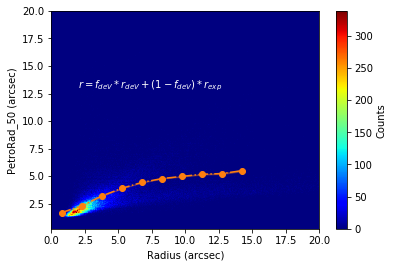

In [30]:
x = data["radius"]
y = data["petro_th50"]

nbins=10

plt.hist2d(x,y,bins=(300, 300),cmap=plt.cm.jet)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

plt.ylabel("PetroRad_50 (arcsec)")
plt.xlabel("Radius (arcsec)")
plt.text(2,13, "$r = f_{deV}*r_{deV}+(1-f_{deV})*r_{exp}$", color= "white")

bin_means,bin_edges, binnumber = binned_statistic(x,y, bins=nbins, range=(0, 15), statistic='mean')

n, _ = np.histogram(x, bins=nbins,range=(0, 15))
sy, _ = np.histogram(x, bins=nbins, range=(0, 15), weights=y)
sy2, _ = np.histogram(x, bins=nbins, range=(0, 15), weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
yerr=std/np.sqrt(n)
print(mean,yerr)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
print(bin_centers,n)

plt.plot(bin_centers,bin_means, 'o-.',color="#ff7f0e",label="HST")
plt.fill_between(bin_centers, bin_means-yerr, bin_means+yerr, alpha=0.3, color='#ff7f0e')

plt.savefig("radii_petro50.png", dpi=300)

[ 5.58867152  8.05095541 10.97397206 12.53747477 13.07389722 13.41524195
 13.36884468 13.90173776 13.7684802  13.85284105] [0.01407462 0.01488247 0.03003456 0.04980286 0.07390369 0.09676464
 0.12604047 0.17270275 0.20586367 0.23526097]
[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.] [28859 77484 30848 14712  8693  5771  3912  2595  1845  1421]


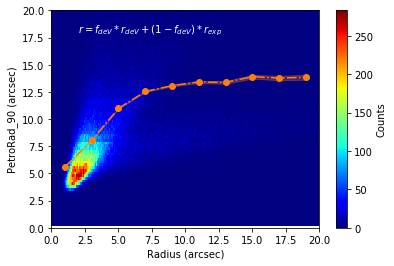

In [31]:
x = data["radius"]
y = data["petro_th90"]

nbins=10

plt.hist2d(x,y,bins=(300, 300),cmap=plt.cm.jet)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

plt.ylabel("PetroRad_90 (arcsec)")
plt.xlabel("Radius (arcsec)")
plt.ylim([0,20])
plt.xlim([0,20])
plt.text(2,18, "$r = f_{deV}*r_{deV}+(1-f_{deV})*r_{exp}$", color= "white")

bin_means,bin_edges, binnumber = binned_statistic(x,y, bins=nbins, range=(0, 20), statistic='mean')

n, _ = np.histogram(x, bins=nbins,range=(0, 20))
sy, _ = np.histogram(x, bins=nbins, range=(0, 20), weights=y)
sy2, _ = np.histogram(x, bins=nbins, range=(0, 20), weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
yerr=std/np.sqrt(n)
print(mean,yerr)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
print(bin_centers,n)

plt.plot(bin_centers,bin_means, 'o-.',color="#ff7f0e",label="HST")
plt.fill_between(bin_centers, bin_means-yerr, bin_means+yerr, alpha=0.3, color='#ff7f0e')

plt.savefig("radii_petro90.png", dpi=300)

In [ ]:
data= Table.read('Tabel_DeCALS_South_sub5.csv', format='csv')
data["radius"] = data["fracdev"]*data["shapedev_r"]+(1-data["fracdev"])*data["shapeexp_r"]
data["mu"] = data["mag_r"]+2.5*np.log10(np.pi*data["radius"]**2)

# Find fraction of galaxies with potentially wrong radii
data_rad=data[(data["radius"]>7.5) & (data["dec"]<0)]


print("Fraction with radius>7.5", len(data_rad)/len(data))

plt.hist(data["radius"], bins=np.linspace(0,20,100))
plt.xlabel("Radius (arcsec)")
plt.ylabel("N")

plt.plot([7.5,7.5],[0,30000], "r--")
plt.xlim(0,15)
plt.savefig("radius_histogram.png", dpi=300)

## Plot magnitude distribution

In [ ]:
plt.hist(data["mag_r"] , bins=np.linspace(14,20,20))
plt.xlabel("Magnitude")
plt.ylabel("N")

plt.savefig("mag_histogram.png", dpi=300)

## Plot surface brightness vs magnitude 

In [ ]:
plt.plot(data["mu"],data["mag_r"],'.',ms=0.2)
plt.xlim(10,40)
plt.ylim(10,20)

plt.xlabel("Surface Brightness (mag/arcsec2)")
plt.ylabel("Magnitude (mag)")

plt.plot([17,17],[10,20], "r--")
plt.savefig("mag_surface_brightness.png", dpi=300)


In [43]:
## fraction of images with my<18 mag/arcsec^2

data_mu=data[data["mu"]<18]

print("Fraction with mu<18:", len(data_mu)/len(data))


Fraction with mu<18: 0.020045510390718096
